# Streamageddon
Spotify's armageddon investments and data science meet
## Preprocessing

In [3]:
%pip install --quiet pandas==2.3.2 wordcloud==1.9.4

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

df_positive = pd.read_csv("artists_positive.csv")
df_negative = pd.read_csv("artists_negative.csv")
df_json = pd.read_json("spotify-artists.json")
df_json_normalized = pd.json_normalize(df_json["artists"])

id = df_json_normalized["id"]
genres = df_json_normalized["genres"]
followers_total = df_json_normalized["followers.total"]
popularity = df_json_normalized["popularity"]
name = df_json_normalized["name"]
# First image of an artist
image = df_json_normalized["images"][0][0]["url"]
data = {"SpotifyId": id,
        "Genres": genres,
        "Followers": followers_total,
        "Popularity": popularity,
        "Image": image}

df_json_final = pd.DataFrame(data)
df = df_json_final.merge(df_positive, on="SpotifyId", how="inner")
df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d")

flat_genres = df.explode("Genres")

unique, counts = np.unique(flat_genres["Genres"], return_counts=True)
print(len(unique))
print(counts)

92
[ 3  5  1  1 20  1  2  6  3  1  1  2  2  1  1  2  1  1  2  1  3  2  2  1
  1 13  1  8 23  1  1  4  2  3  1  1  1  1  1  1  1  1  9  2  4  9  1  3
 11  3  3  2  1  2  2  1  2  1  1  2  6 11  1  1  2  5  1  1  2  1  3  2
  2  1  2  1  7  2 12  1  1  5  2  1  1  4  2  1  4  1  4  1]


## Exploratory data analysis

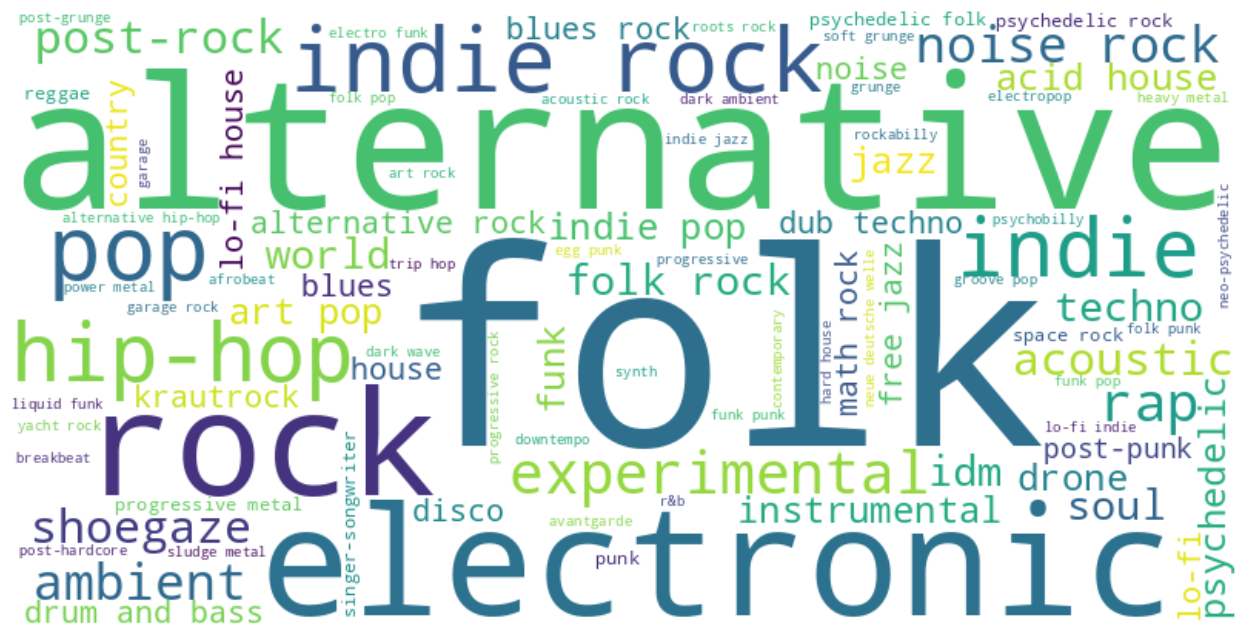

In [5]:
genres_dict = {}
for i in range(len(unique)):
    genres_dict[unique[i]] = counts[i]

wc = WordCloud(width=800, height=400, background_color="white")

wc.generate_from_frequencies(genres_dict)

plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

         Genres  Count
0          folk     23
1   alternative     20
2    electronic     13
3          rock     12
4    indie rock     11
5           pop     11
6       hip-hop      9
7         indie      9
8  experimental      8
9           rap      7


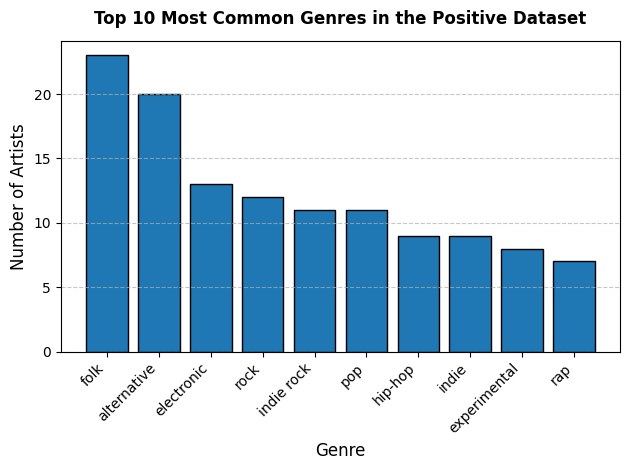

In [6]:
topten = sorted(genres_dict, key=genres_dict.get, reverse=True)[:10]
counts2 = np.asarray(sorted(counts, reverse=True)[:10])
topten_df = pd.DataFrame({"Genres": topten, "Count": counts2.astype(int)})
print(topten_df)

plt.bar(topten_df["Genres"], topten_df["Count"], edgecolor="black")
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number of Artists", fontsize=12)
plt.xticks(rotation=45, horizontalalignment="right", fontsize=10)
plt.yticks(fontsize=10)
plt.title("Top 10 Most Common Genres in the Positive Dataset", fontsize=12, weight="bold", pad=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

In [7]:
avg_popularity = df["Popularity"].mean()
avg_followers = df["Followers"].mean()

print(f"Mean popularity: {avg_popularity}")
print(f"Mean followers: {avg_followers}")

med_popularity = df["Popularity"].median()
med_followers = df["Followers"].median()

print(f"Median popularity: {med_popularity}")
print(f"Median followers: {med_followers}")

Mean popularity: 10.038461538461538
Mean followers: 67606.09615384616
Median popularity: 1.0
Median followers: 550.0


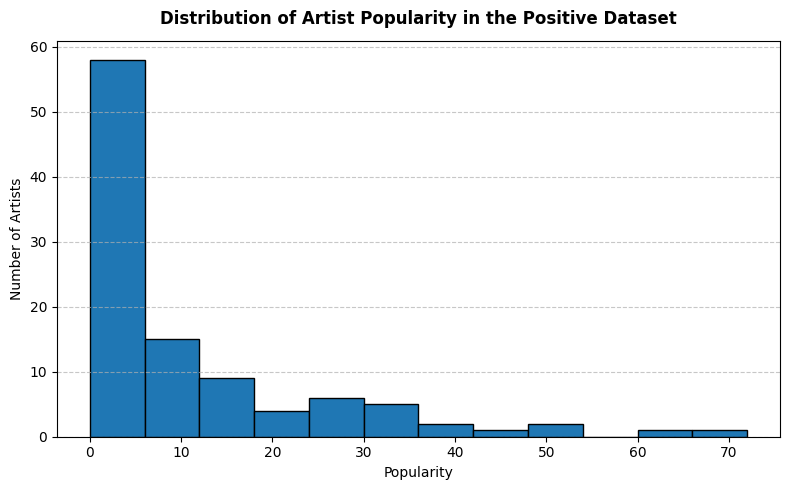

In [8]:
plt.figure(figsize=(8,5))
plt.hist(df["Popularity"], bins=12, edgecolor="black")
plt.xlabel("Popularity")
plt.ylabel("Number of Artists")
plt.title("Distribution of Artist Popularity in the Positive Dataset", fontsize=12, weight="bold", pad=12)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Preprocessing for Machine Learning

In [16]:
# Returns second dataframe where unpopular genres are converted to "other"
def convert_genres(df, genres_list):
    df2 = df
    for genres in df2["Genres"]:
        for i in range(len(genres)):
            if genres[i] not in genres_list:
                genres[i] = "other"
    return df2

# Removes unnecessary columns from the original dataframe if they exist
def drop_columns(df):
    columns = ["SpotifyId", "Image", "Name", "Date"]
    if set(columns).issubset(df.columns):
        df.drop(columns=columns, inplace=True)
    
# Returns second dataframe where genres are a binary variable
# genres_list is a list with genre names to include minus "other"
def genres_as_columns(df, genres_list):
    df2 = df
    zeros = np.zeros(df2.shape[0])
    genres_list2 = genres_list + ["other"]

    for genre in (genres_list2):
        df2[genre] = zeros

    for i in range(df2.shape[0]):
        for genre in df2.at[i, "Genres"]:
            if genre in genres_list2:
                df2.at[i, genre] = 1.0
    return df2

df2_positive = convert_genres(df, topten)
drop_columns(df2_positive)
df2_positive = genres_as_columns(df2_positive, topten)

print(df2_positive)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
99     1.0
100    0.0
101    1.0
102    1.0
103    1.0
Name: other, Length: 104, dtype: float64


# Data analysis